In [3]:
from io import StringIO
import os

import boto3
import pandas as pd

pd.set_option('display.max_columns', 50)


import matplotlib.pyplot as plt
import networkx as nx

import seaborn as sns

In [4]:
aws_access_key_id = os.getenv("AWS_ACCESS_KEY")

aws_secret_key = os.getenv('AWS_SECRET_KEY')

In [5]:
def read_csv_from_s3(bucket: str, path: str, filename: str) -> pd.DataFrame:
    """
    Reads a CSV file from an S3 bucket and returns it as a pandas DataFrame.

    Parameters:
        bucket (str): The name of the S3 bucket.
        path (str): The path within the S3 bucket where the file is located.
        filename (str): The name of the CSV file.

    Returns:
        pd.DataFrame: DataFrame containing the contents of the CSV file.

    """
    s3 = boto3.client('s3', aws_access_key_id=aws_access_key_id, aws_secret_access_key=aws_secret_key)
    
    full_path = f'{path}{filename}'
    
    object = s3.get_object(Bucket=bucket, Key=full_path)
    object = object['Body'].read().decode('utf-8')
    output_df = pd.read_csv(StringIO(object))
    
    return output_df

In [6]:
s3 = boto3.client('s3')
bucket = 'cubix-chicago-taxi-a8i9zm'

community_area_path = 'transformed_data/community_areas/'
company_path = 'transformed_data/company/'
date_path = 'transformed_data/date/'
payment_type_path = 'transformed_data/payment_type/'


community_area = read_csv_from_s3(bucket=bucket, path=community_area_path, filename='community_areas_master.csv')
company = read_csv_from_s3(bucket=bucket, path=company_path, filename='company_master.csv')
date = read_csv_from_s3(bucket=bucket, path=date_path, filename='date_dimension.csv')
payment_type = read_csv_from_s3(bucket=bucket, path=payment_type_path, filename='payment_type_master.csv')


In [7]:
s3 = boto3.client('s3', aws_access_key_id=aws_access_key_id, aws_secret_access_key=aws_secret_key)
taxi_trips_path = 'transformed_data/taxi_trips/'
trips_list = []

# Taxi data transformation and loading
for file in s3.list_objects(Bucket=bucket, Prefix=taxi_trips_path)['Contents']:
    taxi_trip_key = file['Key']
    
    if taxi_trip_key.split('/')[-1].strip() != '':
        if taxi_trip_key.split('.')[1] == 'csv':
            
            filename = taxi_trip_key.split('/')[-1]
                       
            trip = read_csv_from_s3(bucket=bucket, path=taxi_trips_path, filename=filename)

            trips_list.append(trip)
            print(f'{filename} has been added.')
            # response = s3.get_object(Bucket=bucket, Key=taxi_trip_key)
            # content = response['Body']
            # taxi_trip_data_json = json.loads(content.read())
            
            # taxi_trips_raw_data = pd.DataFrame(taxi_trip_data_json)

taxi_2024-03-03.csv has been added.
taxi_2024-03-04.csv has been added.
taxi_2024-03-05.csv has been added.
taxi_2024-03-06.csv has been added.
taxi_2024-03-07.csv has been added.
taxi_2024-03-08.csv has been added.
taxi_2024-03-09.csv has been added.
taxi_2024-03-10.csv has been added.
taxi_2024-03-11.csv has been added.
taxi_2024-03-12.csv has been added.
taxi_2024-03-13.csv has been added.
taxi_2024-03-14.csv has been added.
taxi_2024-03-15.csv has been added.
taxi_2024-03-16.csv has been added.
taxi_2024-03-17.csv has been added.
taxi_2024-03-18.csv has been added.
taxi_2024-03-19.csv has been added.
taxi_2024-03-20.csv has been added.
taxi_2024-03-21.csv has been added.
taxi_2024-03-22.csv has been added.
taxi_2024-03-23.csv has been added.
taxi_2024-03-24.csv has been added.
taxi_2024-03-25.csv has been added.
taxi_2024-03-26.csv has been added.


In [8]:
trips = pd.concat(trips_list, ignore_index=True)

In [9]:
s3 = boto3.client('s3', aws_access_key_id=aws_access_key_id, aws_secret_access_key=aws_secret_key)
weather_path = 'transformed_data/weather/'
weather_list = []

# Taxi data transformation and loading
for file in s3.list_objects(Bucket=bucket, Prefix=weather_path)['Contents']:
    weather_key = file['Key']
    
    if weather_key.split('/')[-1].strip() != '':
        if weather_key.split('.')[1] == 'csv':
            
            filename = weather_key.split('/')[-1]
                       
            weather = read_csv_from_s3(bucket=bucket, path=weather_path, filename=filename)

            weather_list.append(weather)
            print(f'{filename} has been added.')
            # response = s3.get_object(Bucket=bucket, Key=taxi_trip_key)
            # content = response['Body']
            # taxi_trip_data_json = json.loads(content.read())
            
            # taxi_trips_raw_data = pd.DataFrame(taxi_trip_data_json)

weather_2024-03-15.csv has been added.
weather_2024-03-16.csv has been added.
weather_2024-03-17.csv has been added.
weather_2024-03-18.csv has been added.
weather_2024-03-19.csv has been added.
weather_2024-03-20.csv has been added.
weather_2024-03-21.csv has been added.
weather_2024-03-22.csv has been added.
weather_2024-03-23.csv has been added.
weather_2024-03-24.csv has been added.
weather_2024-03-25.csv has been added.
weather_2024-03-26.csv has been added.


In [10]:
weather = pd.concat(weather_list, ignore_index=True)

In [11]:
trips_full = pd.merge(trips, weather, left_on='datetime_for_weather', right_on='datetime', how='inner')
trips_full = trips_full.drop(columns=['datetime'])

trips_full = pd.merge(trips_full, community_area, left_on='pickup_community_area_id', right_on='area_code', how='inner')
trips_full = trips_full.drop(columns=['pickup_community_area_id', 'area_code'])
trips_full.rename(columns={'community_name': 'pickup_community_area_name'}, inplace=True)

trips_full = pd.merge(trips_full, community_area, left_on='dropoff_community_area_id', right_on='area_code', how='inner')
trips_full = trips_full.drop(columns=['dropoff_community_area_id', 'area_code'])
trips_full.rename(columns={'community_name': 'dropoff_community_area_name'}, inplace=True)

trips_full = pd.merge(trips_full, company, on='company_id', how='inner')
trips_full = trips_full.drop(columns=['company_id'])
trips_full = pd.merge(trips_full, payment_type, on='payment_type_id', how='inner')
trips_full = trips_full.drop(columns=['payment_type_id'])

In [12]:
date['date'] = pd.to_datetime(date['date'])

trips_full['trip_start_timestamp'] = pd.to_datetime(trips_full['trip_start_timestamp'])

#trips_full['trip_start_date'] = trips_full['trip_start_timestamp']

# trips_full['trip_start_date'] = pd.to_datetime(trips_full['trip_start_date'])
trips_full['trip_start_date'] = trips_full['trip_start_timestamp'].dt.date

trips_full['trip_start_date'] = pd.to_datetime(trips_full['trip_start_date'])

trips_full = pd.merge(trips_full, date, left_on='trip_start_date', right_on='date', how='inner')
trips_full.head()
trips_full = trips_full.drop(columns=['date'])

In [13]:
trips_full.head()

,trip_id,taxi_id,trip_start_timestamp,trip_end_timestamp,trip_seconds,trip_miles,fare,tips,tolls,extras,trip_total,pickup_centroid_latitude,pickup_centroid_longitude,dropoff_centroid_latitude,dropoff_centroid_longitude,datetime_for_weather,temperature,wind_speed,precipitation,rain,pickup_community_area_name,dropoff_community_area_name,company,payment_type,trip_start_date,year,month,day,day_of_week,is_weekend
0,00c6d0cc3d95795a2b9cb3fcbb3afa8eed897ac7,3ae83cc261cea27eafc3d9b18bbc93100c03762e8b6971...,2024-03-15 23:45:00,2024-03-16T00:15:00.000,1680,1.00,42.25,9.55,0.0,5.0,56.8,41.979071,-87.903040,41.884987,-87.620993,2024-03-15 23:00:00,4.7,9.8,0.0,0.0,O'Hare,Loop,Taxi Affiliation Services,Credit Card,2024-03-15,2024,3,15,5,False
1,fd729619c5458746ffe602406d2f86cb4059ee35,3c814d3baedca9be4de8ddb5547c7dec404a08e148740e...,2024-03-15 23:45:00,2024-03-16T00:15:00.000,1569,18.06,44.50,14.70,0.0,4.0,63.7,41.980264,-87.913625,41.899602,-87.633308,2024-03-15 23:00:00,4.7,9.8,0.0,0.0,O'Hare,Near North Side,Sun Taxi,Credit Card,2024-03-15,2024,3,15,5,False
2,f8aef1517ec3953a3805d0912f92f994e1245205,9de14279ac4dc5696c73c13b07b0aaf2b1a1796dda9f4c...,2024-03-15 23:45:00,2024-03-15T23:45:00.000,336,1.64,10.00,2.00,0.0,0.0,12.0,41.922761,-87.699155,41.901207,-87.676356,2024-03-15 23:00:00,4.7,9.8,0.0,0.0,Logan Square,West Town,City Service,Mobile,2024-03-15,2024,3,15,5,False
3,efa623a2405100c731e62efc223d3c02ddee3d8a,8a999732f0972dda5aa358ad377427f0cb844b5ec246a9...,2024-03-15 23:45:00,2024-03-16T00:00:00.000,1370,5.51,18.50,0.00,0.0,1.0,19.5,41.812949,-87.617860,41.899602,-87.633308,2024-03-15 23:00:00,4.7,9.8,0.0,0.0,Grand Boulevard,Near North Side,Flash Cab,Prcard,2024-03-15,2024,3,15,5,False
4,ebbf769b25db8056d8ffc0b27f982ac1102eab4e,7ff3ea8c15d902e432f0f3ca3aab1d5f20bff4c4fedfb5...,2024-03-15 23:45:00,2024-03-15T23:45:00.000,600,2.30,9.00,2.10,0.0,1.0,12.1,41.944227,-87.655998,41.899602,-87.633308,2024-03-15 23:00:00,4.7,9.8,0.0,0.0,Lake View,Near North Side,Taxi Affiliation Services,Credit Card,2024-03-15,2024,3,15,5,False


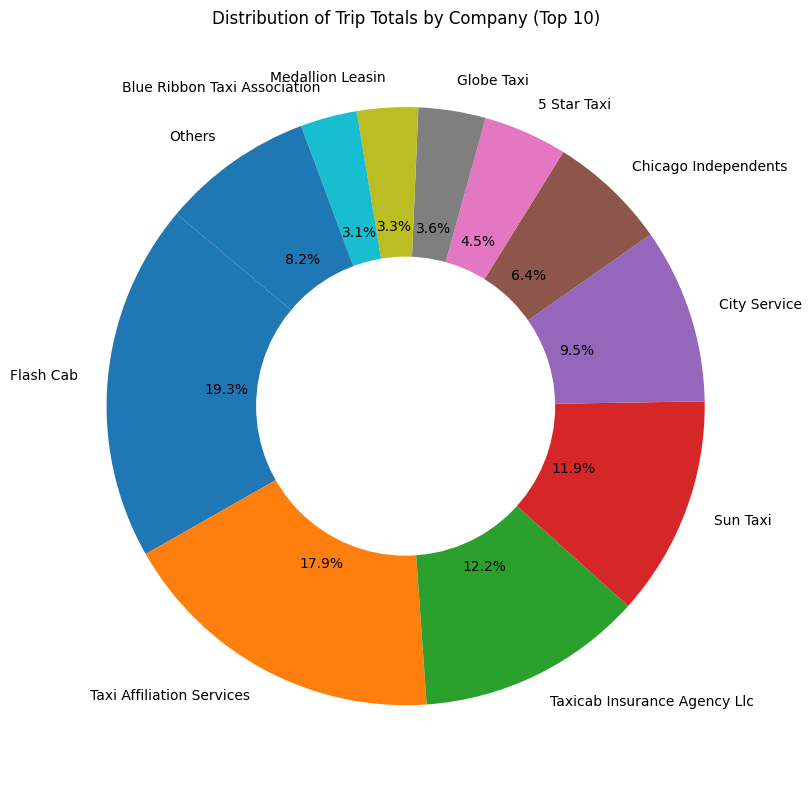

In [43]:
# Group the data by company and sum the trip_total
company_trip_totals = trips_full.groupby('company')['trip_total'].sum()

# Sort the companies by trip_total in descending order and get the top 5
top_5_companies = company_trip_totals.nlargest(10)
other_companies_total = company_trip_totals.sum() - top_5_companies.sum()

# Create a new series that includes the top 5 companies and a category for "Others"
company_trip_totals_top_5 = pd.concat([top_5_companies, pd.Series({'Others': other_companies_total})])

# Create a pie chart
plt.figure(figsize=(100, 8))
wedges, texts, autotexts = plt.pie(company_trip_totals_top_5, labels=company_trip_totals_top_5.index, autopct='%1.1f%%', startangle=140)

# Draw a circle at the center of pie to make it look like a donut
centre_circle = plt.Circle((0, 0), 0.50, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Distribution of Trip Totals by Company (Top 10)')
plt.tight_layout()
plt.show()


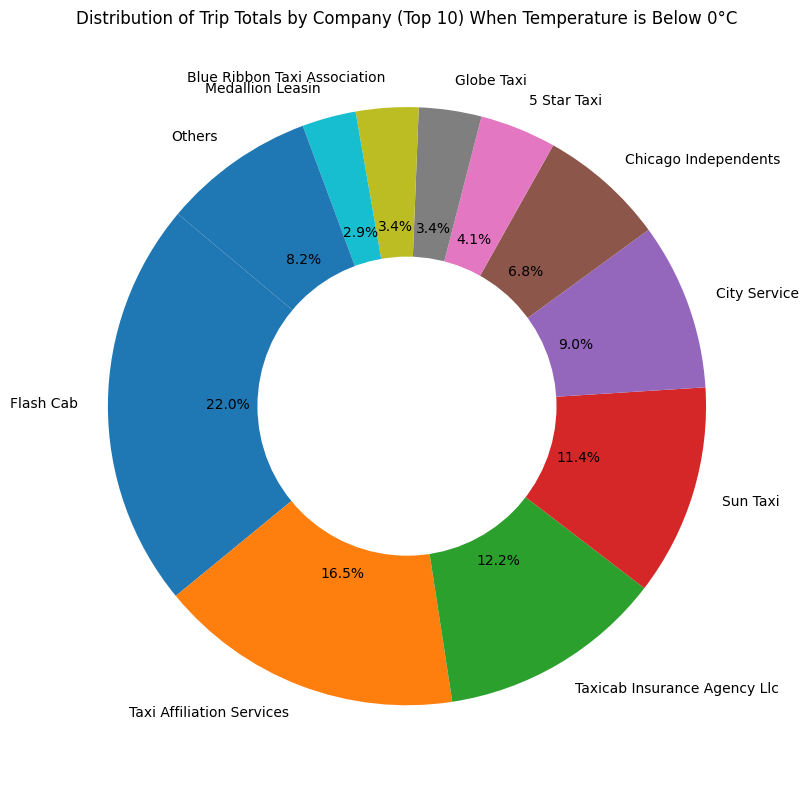

In [45]:
import matplotlib.pyplot as plt
import pandas as pd

# Filter the data for trips with temperature below 0
trips_below_zero = trips_full[trips_full['temperature'] < 0]

# Group the data by company and sum the trip_total
company_trip_totals_below_zero = trips_below_zero.groupby('company')['trip_total'].sum()

# Sort the companies by trip_total in descending order and get the top 10
top_10_companies_below_zero = company_trip_totals_below_zero.nlargest(10)
other_companies_total_below_zero = company_trip_totals_below_zero.sum() - top_10_companies_below_zero.sum()

# Create a new series that includes the top 10 companies and a category for "Others"
company_trip_totals_top_10_below_zero = pd.concat([top_10_companies_below_zero, pd.Series({'Others': other_companies_total_below_zero})])

# Create a pie chart
plt.figure(figsize=(10, 8))
wedges, texts, autotexts = plt.pie(company_trip_totals_top_10_below_zero, labels=company_trip_totals_top_10_below_zero.index, autopct='%1.1f%%', startangle=140)

# Draw a circle at the center of pie to make it look like a donut
centre_circle = plt.Circle((0, 0), 0.50, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Distribution of Trip Totals by Company (Top 10) When Temperature is Below 0°C')
plt.tight_layout()
plt.show()


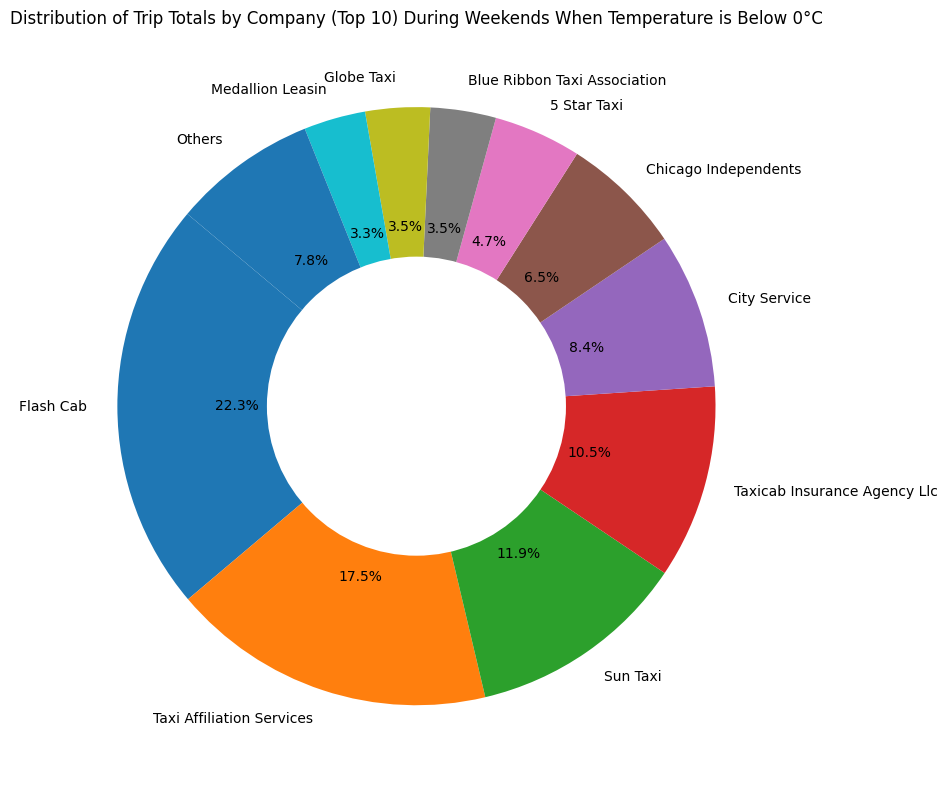

In [46]:
# Filter the data for trips with temperature below 0 and during weekends
trips_below_zero_weekend = trips_full[(trips_full['temperature'] < 0) & (trips_full['is_weekend'] == True)]

# Group the data by company and sum the trip_total
company_trip_totals_below_zero_weekend = trips_below_zero_weekend.groupby('company')['trip_total'].sum()

# Sort the companies by trip_total in descending order and get the top 10
top_10_companies_below_zero_weekend = company_trip_totals_below_zero_weekend.nlargest(10)
other_companies_total_below_zero_weekend = company_trip_totals_below_zero_weekend.sum() - top_10_companies_below_zero_weekend.sum()

# Create a new series that includes the top 10 companies and a category for "Others"
company_trip_totals_top_10_below_zero_weekend = pd.concat([top_10_companies_below_zero_weekend, pd.Series({'Others': other_companies_total_below_zero_weekend})])

# Create a pie chart
plt.figure(figsize=(10, 8))
wedges, texts, autotexts = plt.pie(company_trip_totals_top_10_below_zero_weekend, labels=company_trip_totals_top_10_below_zero_weekend.index, autopct='%1.1f%%', startangle=140)

# Draw a circle at the center of pie to make it look like a donut
centre_circle = plt.Circle((0, 0), 0.50, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Distribution of Trip Totals by Company (Top 10) During Weekends When Temperature is Below 0°C')
plt.tight_layout()
plt.show()


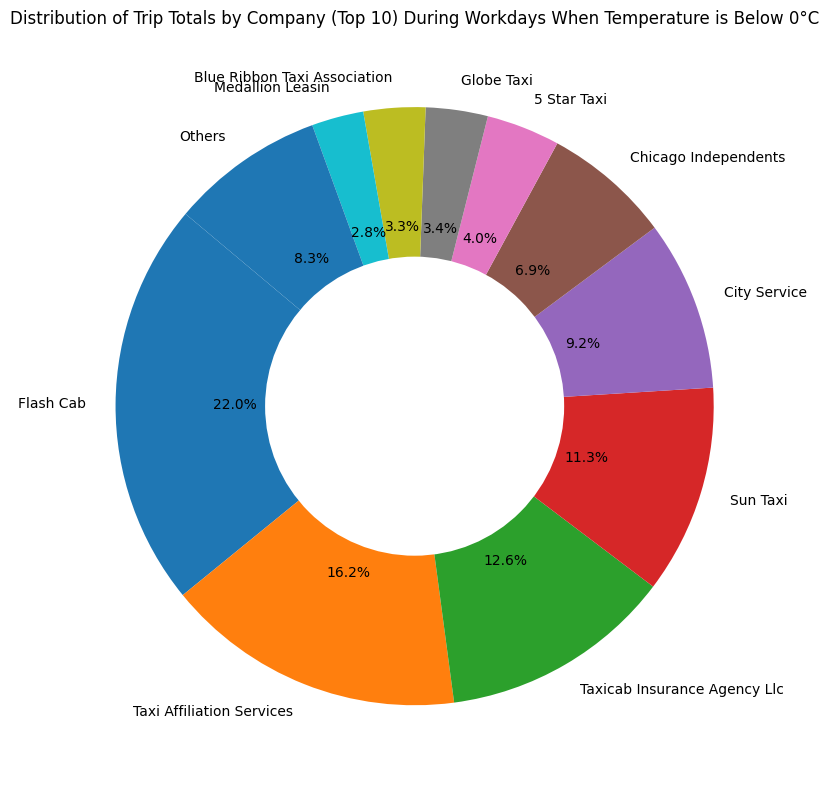

In [47]:
# Filter the data for trips with temperature below 0 and during workdays
trips_below_zero_workday = trips_full[(trips_full['temperature'] < 0) & (trips_full['is_weekend'] == False)]

# Group the data by company and sum the trip_total
company_trip_totals_below_zero_workday = trips_below_zero_workday.groupby('company')['trip_total'].sum()

# Sort the companies by trip_total in descending order and get the top 10
top_10_companies_below_zero_workday = company_trip_totals_below_zero_workday.nlargest(10)
other_companies_total_below_zero_workday = company_trip_totals_below_zero_workday.sum() - top_10_companies_below_zero_workday.sum()

# Create a new series that includes the top 10 companies and a category for "Others"
company_trip_totals_top_10_below_zero_workday = pd.concat([top_10_companies_below_zero_workday, pd.Series({'Others': other_companies_total_below_zero_workday})])

# Create a pie chart
plt.figure(figsize=(10, 8))
wedges, texts, autotexts = plt.pie(company_trip_totals_top_10_below_zero_workday, labels=company_trip_totals_top_10_below_zero_workday.index, autopct='%1.1f%%', startangle=140)

# Draw a circle at the center of pie to make it look like a donut
centre_circle = plt.Circle((0, 0), 0.50, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Distribution of Trip Totals by Company (Top 10) During Workdays When Temperature is Below 0°C')
plt.tight_layout()
plt.show()


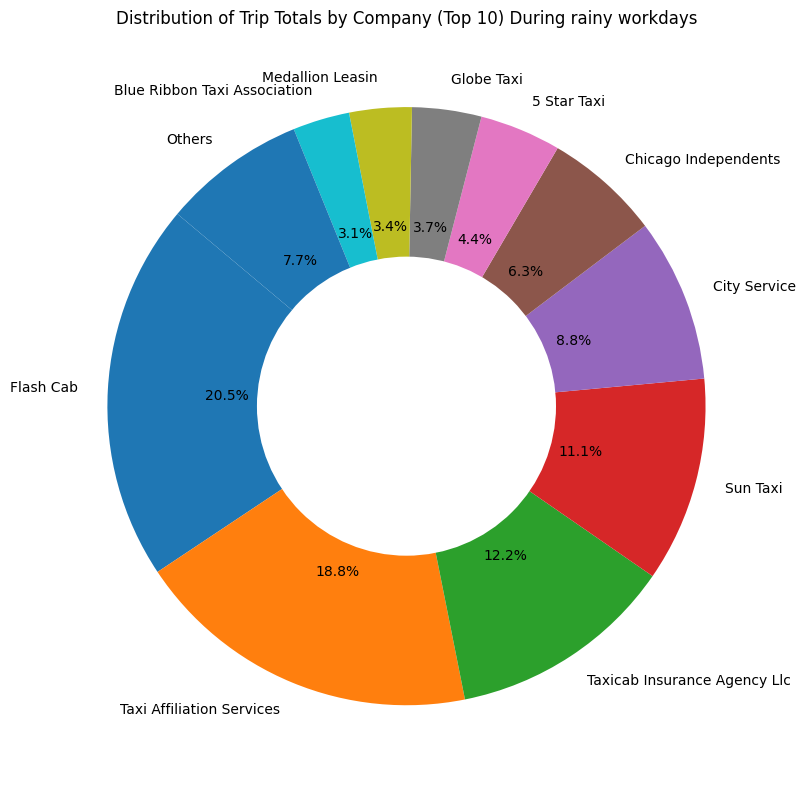

In [51]:
# Filter the data for trips with rain greater than 0 and during workdays
trips_rainy_workday = trips_full[(trips_full['rain'] > 0) & (trips_full['is_weekend'] == False)]

# Group the data by company and sum the trip_total
company_trip_totals_rainy_workday = trips_rainy_workday.groupby('company')['trip_total'].sum()

# Sort the companies by trip_total in descending order and get the top 10
top_10_companies_rainy_workday = company_trip_totals_rainy_workday.nlargest(10)
other_companies_total_rainy_workday = company_trip_totals_rainy_workday.sum() - top_10_companies_rainy_workday.sum()

# Create a new series that includes the top 10 companies and a category for "Others"
company_trip_totals_top_10_rainy_workday = pd.concat([top_10_companies_rainy_workday, pd.Series({'Others': other_companies_total_rainy_workday})])

# Create a pie chart
plt.figure(figsize=(10, 8))
wedges, texts, autotexts = plt.pie(company_trip_totals_top_10_rainy_workday, labels=company_trip_totals_top_10_rainy_workday.index, autopct='%1.1f%%', startangle=140)

# Draw a circle at the center of pie to make it look like a donut
centre_circle = plt.Circle((0, 0), 0.50, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Distribution of Trip Totals by Company (Top 10) During rainy workdays')
plt.tight_layout()
plt.show()
